In [1]:
from fastai.vision.all import *
from matplotlib import patches
import torch
import numpy as np

Libraries Used: PyTorch
                Numpy
                FastAI
                Matplotlib

In [2]:
path = untar_data("https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip")

In [3]:
list(path.iterdir())

[Path('/home/ubuntu/.fastai/data/fire-dataset/train'),
 Path('/home/ubuntu/.fastai/data/fire-dataset/validation'),
 Path('/home/ubuntu/.fastai/data/fire-dataset/tmp')]

In [4]:
path.ls()

(#3) [Path('/home/ubuntu/.fastai/data/fire-dataset/train'),Path('/home/ubuntu/.fastai/data/fire-dataset/validation'),Path('/home/ubuntu/.fastai/data/fire-dataset/tmp')]

In [5]:
train_path = path/'train'

In [6]:
train_path.ls()

(#2) [Path('/home/ubuntu/.fastai/data/fire-dataset/train/images'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations')]

In [7]:
train_annotations = train_path/'annotations'
train_imgs = train_path/'images'

In [8]:
train_imgs.ls()

(#413) [Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/pic (160).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/pic (81).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/pic (124).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/pic (137).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/img (47).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/pic (202).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/img (135).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/small (122).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/img (110).jpg'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/images/pic (39).jpg')...]

In [9]:
train_annotations.ls()

(#412) [Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/pic (170).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/img (31).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/img (120).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/pic (110).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/pic (37).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/img (65).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/img (95).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/small (137).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/small (53).xml'),Path('/home/ubuntu/.fastai/data/fire-dataset/train/annotations/small (105).xml')...]

In [10]:
import xml.etree.ElementTree as ET

Read bbox coordinates from xml files and creating tuples with img and bbox.
Note that the bounding box is in the form:  


                   (x1,y1)----------
                    |              |
                    |              |
                    |              |
                    |              |
                    -------------(x2,y2)
       
       
bbox = (x1,y1,x2,y2)

In [11]:
def get_anns(file_path):
    file = open(file_path)
    tree = ET.parse(file)
    root = tree.getroot()
    img = root[1].text
    bboxs = [int(root[6][4][0].text), int(root[6][4][3].text), int(root[6][4][2].text), int(root[6][4][1].text)]
    return img,bboxs

In [12]:
a, b = get_anns(train_annotations.ls()[0])
a, b

('pic (170).jpg', [105, 129, 186, 12])

In [13]:
imgs, bboxs = [get_anns(path)[0] for path in train_annotations.ls()], [get_anns(path)[1] for path in train_annotations.ls()]

In [14]:
imgs[0], bboxs[0]

('pic (170).jpg', [105, 129, 186, 12])

Lets collect bboxs and img names into a dictionary

In [15]:
train_anns = collections.defaultdict(lambda:[])

for img, bbox in zip(imgs,bboxs):
    train_anns[img].append(bbox)
len(train_anns)

412

In [16]:
train_anns[imgs[0]][0]

[105, 129, 186, 12]

In [17]:
imgs[0]

'pic (170).jpg'

When plotting bboxs, the library needs the inputs in the form of: (x,y,w,h)

                       <--- w --->
                  ^  ----------------
                  | |              |
                  h |              |
                  | |              |
                    |              |
                  (x,y)-------------

In [18]:
def bb_hw(b):
    return np.array([b[0], b[3], b[2]-b[0], b[1]-b[3]])

In [19]:
def show_img(img, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [20]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), 
                        patheffects.Normal()])

In [21]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))

(array([167,  58]), 80, 84, array([167,  58,  80,  84]))

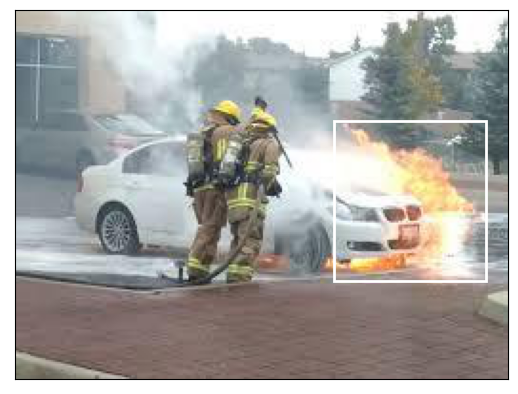

In [22]:
im = Image.open(train_imgs/imgs[4])
ax = show_img(im)
b = bb_hw(bboxs[4])
draw_rect(ax, b)
b[:2], *b[-2:], b

In [23]:
bboxs[4], imgs[4]

([167, 142, 247, 58], 'pic (37).jpg')

In [24]:
def draw_img(im, ann):
    ax = show_img(im, figsize=(16,8))
    b = bb_hw(ann)
    draw_rect(ax, b)

In [25]:
getters = [lambda o: train_imgs/o, lambda o: torch.tensor(np.array(train_anns[o][0])).reshape(2,2)]

Tranformations appliedfor augmentation: rotate, flip and dihedral

In [26]:
item_tfms = [Resize(224, method='squish'),]
batch_tfms = [Rotate(), Flip(),Dihedral()]

In [27]:
db = DataBlock(blocks=(ImageBlock, PointBlock),
                 splitter=RandomSplitter(),
                 getters = getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp = 1)

In [28]:
db.summary(imgs)

Setting-up type transforms pipelines
Found 412 items
2 datasets of sizes 330,82
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> TensorPoint.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      pic (203).jpg
    applying <lambda> gives
      /home/ubuntu/.fastai/data/fire-dataset/train/images/pic (203).jpg
    applying PILBase.create gives
      PILImage mode=RGB size=275x183
  Pipeline: <lambda> -> TensorPoint.create
    starting from
      pic (203).jpg
    applying <lambda> gives
      Tensor of size 2x2
    applying TensorPoint.create gives
      TensorPoint of size 2x2

Final sample: (PILImage mode=RGB size=275x183, TensorPoint([[103., 125.],
             [243.,  49.]]))


Found 412 items
2 datasets of sizes 330,82
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> TensorPoint.create
Setting up after_item: Pipeline: PointScaler -> Resize -- {'size': (224, 224), 'method': 'squish', '

In [29]:
imgs[0]

'pic (170).jpg'

In [30]:
torch.tensor(np.array(train_anns['pic (170).jpg'][0])).reshape(2,2)

tensor([[105, 129],
        [186,  12]])

In [31]:
db.summary(imgs, bs=16)

Setting-up type transforms pipelines
Found 412 items
2 datasets of sizes 330,82
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> TensorPoint.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      small (36).jpg
    applying <lambda> gives
      /home/ubuntu/.fastai/data/fire-dataset/train/images/small (36).jpg
    applying PILBase.create gives
      PILImage mode=RGB size=183x275
  Pipeline: <lambda> -> TensorPoint.create
    starting from
      small (36).jpg
    applying <lambda> gives
      Tensor of size 2x2
    applying TensorPoint.create gives
      TensorPoint of size 2x2

Final sample: (PILImage mode=RGB size=183x275, TensorPoint([[122., 139.],
             [134., 125.]]))


Found 412 items
2 datasets of sizes 330,82
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> TensorPoint.create
Setting up after_item: Pipeline: PointScaler -> Resize -- {'size': (224, 224), 'method': 'squish'

In [32]:
dls = db.dataloaders(imgs, bs = 64)

In [33]:
dls.c = dls.train.after_item.c

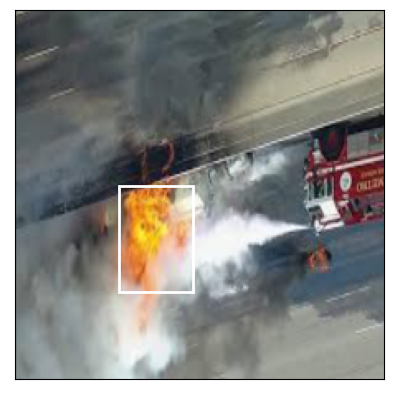

In [34]:
x,y=dls.one_batch()
#y[0].flatten().shape,y[0].flatten()
xd,yd= dls.decode_batch((x,y))[0]
ax = show_img(xd.permute(1,2,0))
b = bb_hw(list(yd.flatten()))
draw_rect(ax, b)
#b

Iniializing the body with resnet34 backbone

In [35]:
body = create_body(resnet34(), pretrained=True)
body[-1][-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Head takes the features from the body and outputs 4 coordinates

In [36]:
head = create_head(nf=512, n_out=4); head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [37]:
arch = nn.Sequential(body, head)

In [38]:
arch[1:]

Sequential(
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): fastai.layers.Flatten(full=False)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=4, bias=False)
  )
)

In [39]:
apply_init(arch[1], nn.init.kaiming_normal_)

In [47]:


learn = Learner(dls,arch,loss_func=MSELossFlat(),opt_func=ranger, 
                       metrics=accuracy_multi)

In [44]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [49]:
learn.freeze()

SuggestedLRs(valley=0.0063095735386013985)

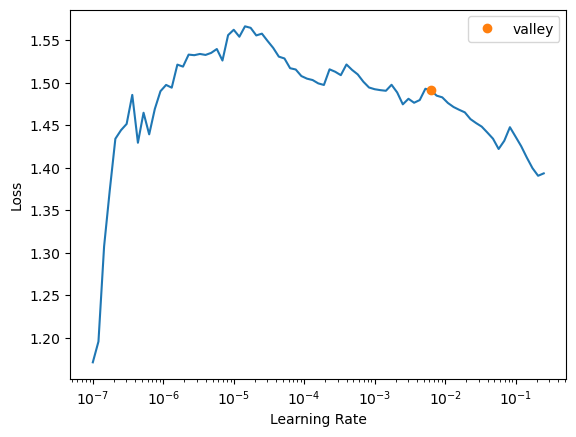

In [50]:
learn.lr_find()

In [52]:
learn.fit_flat_cos(15, 6e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,4.284301,2.058827,0.411585,01:59
1,3.775664,0.314735,0.329268,01:37
2,3.688229,0.211771,0.371951,01:41
3,4.153378,0.356230,0.435976,01:41
4,4.067586,0.342549,0.481707,01:42
5,4.039752,0.333357,0.469512,01:39
6,4.095760,0.352784,0.490854,01:14
7,4.381715,3.486351,0.457317,01:13
8,4.292536,5.082278,0.442073,01:12
9,4.316637,13.113968,0.417683,01:09


In [53]:
learn.unfreeze()

SuggestedLRs(valley=5.248074739938602e-05)

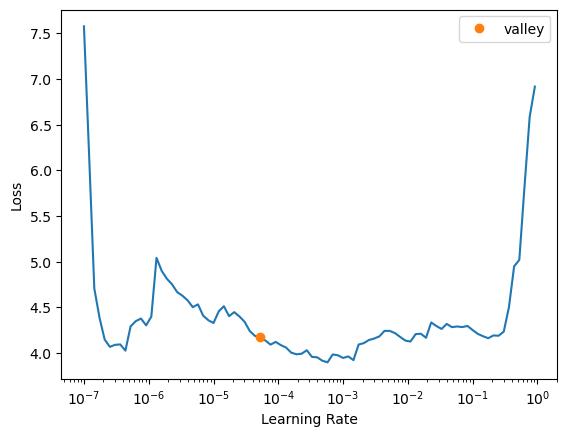

In [55]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(15, 5.2e-5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,4.188434,0.323866,0.493902,01:56
1,3.829624,0.330254,0.503049,01:52
2,3.930260,0.287647,0.506098,01:42
3,3.987937,0.267559,0.506098,01:42
4,3.991798,0.261610,0.506098,01:40
5,3.942083,0.252201,0.506098,01:45
6,3.783221,0.250580,0.487805,01:55
7,3.942812,0.253918,0.463415,02:00
8,4.105842,0.258846,0.484756,01:44
9,3.957835,0.252027,0.493902,01:17


In [37]:
learn.save('fire-det')